# EU Tariffs

## Data

- Impex 2d: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007
- Impex 8d: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0015

## Notes

- Combined Nomenclature: https://taxation-customs.ec.europa.eu/customs-4/calculation-customs-duties/customs-tariff/combined-nomenclature_de
- a.n.g. = anderweitig nicht genannt


In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import squarify
import sys
import os
from io import StringIO
from dotenv import dotenv_values
secrets = dotenv_values(".env") 

sys.path.append('..')
from utils.get_destatis_variable_values import get_destatis_variable_values
from utils.get_destatis_table import get_destatis_table

In [13]:
raw = {
    "impex2d": pd.read_csv("./data/51000-0007_de_flat.csv",
                               	delimiter=";",
                               	decimal=",",
                               	thousands=".",
                               	parse_dates=["time"],
                               	converters={ "value": lambda x: pd.to_numeric(x, errors="coerce")}),
	"impex8d": pd.read_csv("./data/51000-0013_de_flat.csv",
								delimiter=";",
								decimal=",",
								thousands=".",
								parse_dates=["time"],
								converters={"value": lambda x: pd.to_numeric(x, errors="coerce")})
}

In [ ]:
def try_cache(cache_path: str, fetch_fn):
	try:
		with open(cache_path, "r") as f:
			print(f"Loaded cached data from {cache_path}")
			return f.read()
	except FileNotFoundError:	
		print(f"Cache miss, fetching...", end="")
		text = fetch_fn()
		print(f"done, writing to {cache_path}", end="")
		with open(cache_path, "w") as f:
			f.write(text)
		return text

In [ ]:
raw["impex4d"] = try_cache("./data/impex-4d.csv",
	lambda: get_destatis_table(
		token=os.getenv("DESTATIS_TOKEN"),
		password=os.getenv("V_4QarpjUaS3Q9is_w_7"),
		tables=["51000-0009"],
		start_year=2024,
		attributes={
			"STLAH": "STLAH400", # destination country code
			"WAM4": "*" # product code
			}
		)
)


Found cached data at ./test.csv


In [ ]:
raw["country_codes"] = try_cache("./data/genesis-countries.json", lambda: get_destatis_variable_values(var="STLAH", token=secrets["DESTATIS_TOKEN"]))
raw["product_codes"] = try_cache("./data/genesis-products-4d.json", lambda: get_destatis_variable_values(var="WAM4", token=secrets["DESTATIS_TOKEN"]))

Found cached data at ./genesis-countries.json
Found cached data at ./genesis-products-4d.json


In [13]:
data = {
    "impex2d": raw["impex2d"][["statistics_code", "time","1_variable_attribute_label", "2_variable_attribute_label", "3_variable_attribute_code", "3_variable_attribute_label", "value", "value_unit", "value_variable_label", "value_q"]].rename(columns={
        "1_variable_attribute_label": "destination",
        "2_variable_attribute_label": "origin",
        "3_variable_attribute_code": "product_code",
        "3_variable_attribute_label": "product_label",
	}),
    "impex4d": pd.read_csv(StringIO(raw["impex4d"]),
                           header=5,
                           skiprows=[6],
                           skipfooter=3,
                           engine="python",
                           decimal=",",
                           thousands=".",
                           sep=";").rename(columns={
    								"Unnamed: 0": "year",
    								"Unnamed: 1": "country",
    								"Unnamed: 2": "product_code",
    								"Unnamed: 3": "product_label",
	}),
    "impex8d": raw["impex8d"][["time", "value_variable_label", "value", "value_unit","1_variable_attribute_label", "2_variable_attribute_code","2_variable_attribute_label", "statistics_code","value_q"]].rename(columns={
        "2_variable_attribute_code": "product_code",
        "2_variable_attribute_label": "product_label",
	})
}

data["impex4d"]

,year,country,product_code,product_label,Ausfuhr: Gewicht,Ausfuhr: Wert,Ausfuhr: Wert (US-Dollar),Einfuhr: Gewicht,Einfuhr: Wert,Einfuhr: Wert (US-Dollar)
0,2024,Vereinigte Staaten von Amerika,WA0101,"Pferde, Esel, Maultiere und Maulesel, lebend",717.2,142224,153153,69.2,3379,3642
1,2024,Vereinigte Staaten von Amerika,WA0102,"Rinder, lebend",-,-,-,-,-,-
2,2024,Vereinigte Staaten von Amerika,WA0103,"Schweine, lebend",-,-,-,-,-,-
3,2024,Vereinigte Staaten von Amerika,WA0104,"Schafe und Ziegen, lebend",-,-,-,-,-,-
4,2024,Vereinigte Staaten von Amerika,WA0105,"Hausgeflügel, lebend",-,-,-,0.4,64,69
...,...,...,...,...,...,...,...,...,...,...
1621,2024,Vereinigte Staaten von Amerika,WA9919,"Aussteuer, Erbschaftsgut, Ware f. Wohlfahrtspf...",-,-,-,-,-,-
1622,2024,Vereinigte Staaten von Amerika,WA9930,Schiffsbedarf und Luftfahrzeugbedarf,7979.6,62467,67591,-,-,-
1623,2024,Vereinigte Staaten von Amerika,WA9931,Güter für Einrichtungen auf hoher See,-,-,-,-,-,-
1624,2024,Vereinigte Staaten von Amerika,WA9988,Sperrungen in der Außenhandelsstatistik,41384.1,229852,248931,0.4,1,1


In [14]:
d = data["impex2d"].loc[
    data["impex2d"]["value_variable_label"] == "Einfuhr: Wert"
].nlargest(15, ["value"])


In [15]:
d = data["impex8d"].loc[
    data["impex8d"]["value_variable_label"] == "Einfuhr: Wert"
]

# d.nlargest(5, ["value"])
# impex8d_raw

In [20]:
soy_codes = [
    "WA12019000",
    "WA12081000",
    "WA15071090",
    "WA15079090",
    "WA21031000",
    "WA22029911",
    "WA22029915"
]

pd.set_option('display.max_colwidth', None)
d = data["impex8d"].loc[
    (data["impex8d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex8d"]["product_label"].str.contains("Soja"))
].sort_values("value", ascending=False)[["time", "product_label", "product_code", "value", "value_unit"]]

d

,time,product_label,product_code,value,value_unit
71189,2024-01-01,"Sojabohnen, auch geschrotet, a.n.g.",WA12019000,1630299.0,Tsd. EUR
26877,2024-01-01,Ölkuchen u.a. feste Rückstände von Sojaöl,WA23040000,1120665.0,Tsd. EUR
54501,2024-01-01,"Getränke aus Soja, Nüssen, Samen, a.n.g. l",WA22029915,190950.0,Tsd. EUR
71845,2024-01-01,"Rohes Sojaöl, zur Verwendung als Lebensmittel",WA15071090,56707.0,Tsd. EUR
106981,2024-01-01,"Sojasoße, zubereitet",WA21031000,50471.0,Tsd. EUR
53749,2024-01-01,"Sojaöl, raffiniert, zu Lebensmittelzwecken",WA15079090,48251.0,Tsd. EUR
19653,2024-01-01,"Rohes Sojaöl, zu industriellen Zwecken",WA15071010,38385.0,Tsd. EUR
53765,2024-01-01,"Getränke aus Soja, Eiweißgehalt >= 2,8 GHT l",WA22029911,36122.0,Tsd. EUR
18837,2024-01-01,Mehl von Sojabohnen,WA12081000,9238.0,Tsd. EUR
87621,2024-01-01,Sojabohnen zur Aussaat,WA12011000,5822.0,Tsd. EUR


## Welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert?

[Tamara Land](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D): 

> Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.

In [ ]:
food_codes = [
    "WA01",
    "WA02",
    "WA03",
    "WA04",
    "WA05",
    "WA07",
    "WA08",
    "WA09",
    "WA10",
    "WA11",
    "WA15",
    "WA16",
    "WA17",
    "WA18",
    "WA19",
    "WA20",
    "WA21",
    "WA22",
]
d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(food_codes))
].sort_values("value", ascending=False).reset_index()[:10]

d[["index", "time", "origin", "product_code", "product_label", "value", "value_unit"]]


,index,time,origin,product_code,product_label,value,value_unit
0,95759,2024-01-01,Vereinigte Staaten von Amerika,WA08,Genießbare Früchte und Nüsse,912342.0,Tsd. EUR
1,102065,2024-01-01,Vereinigte Staaten von Amerika,WA22,"Getränke, alkoholhaltige Flüssigkeiten, Essig",255691.0,Tsd. EUR
2,96485,2024-01-01,Vereinigte Staaten von Amerika,WA03,"Fische, Krebs- und Weichtiere",187111.0,Tsd. EUR
3,102215,2024-01-01,Vereinigte Staaten von Amerika,WA21,Verschiedene Lebensmittelzubereitungen,133619.0,Tsd. EUR
4,102365,2024-01-01,Vereinigte Staaten von Amerika,WA20,"Zubereitungen von Gemüse, Früchten usw.",61437.0,Tsd. EUR
5,95921,2024-01-01,Vereinigte Staaten von Amerika,WA07,"Gemüse, Pflanzen für Ernährung",42963.0,Tsd. EUR
6,96587,2024-01-01,Vereinigte Staaten von Amerika,WA02,Fleisch,31596.0,Tsd. EUR
7,96209,2024-01-01,Vereinigte Staaten von Amerika,WA05,Andere Waren tierischen Ursprungs,29138.0,Tsd. EUR
8,101411,2024-01-01,Vereinigte Staaten von Amerika,WA15,"Tierische und pflanzliche Fette, Öle, Wachs",27894.0,Tsd. EUR
9,100901,2024-01-01,Vereinigte Staaten von Amerika,WA18,Kakao und Zubereitungen aus Kakao,22296.0,Tsd. EUR


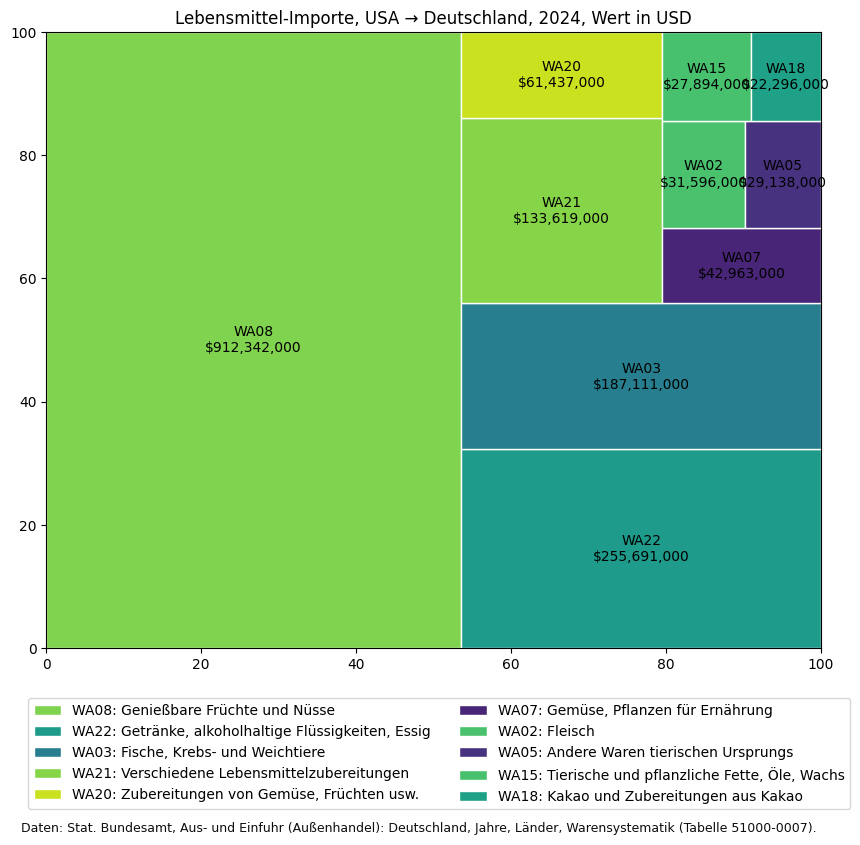

In [ ]:
d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(food_codes))
].sort_values("value", ascending=False).reset_index()[:10]

fig, ax = plt.subplots(figsize=(10,8))
plt.title("Lebensmittel-Importe, USA → Deutschland, 2024, Wert in USD")

d = d.sort_values("value", ascending=False)
short_label = d["product_code"] + "\n" + d["value"].apply(lambda x: f"${round(x)*1000:,}")
long_label = d["product_code"] + ": " + d["product_label"]
# values = [10,50,130,140]
squarify.plot(d["value"], label=short_label, edgecolor="white")
fig.legend(long_label, loc="lower left", ncols=2, bbox_to_anchor=(.1, -.1, .8, 1))
ax.text(x=.1, y=-0.12, s="Daten: Stat. Bundesamt, Aus- und Einfuhr (Außenhandel): Deutschland, Jahre, Länder, Warensystematik (Tabelle 51000-0007).", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()

In [17]:
d = data["impex8d"].loc[
    (data["impex8d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex8d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex8d"]["product_code"].isin(food_codes))
].sort_values("value", ascending=False).reset_index()[:10]

d

KeyError: 'origin'